In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim import Adam, RMSprop, SGD
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from torchvision.transforms import Resize, ToTensor, RandomHorizontalFlip, Normalize,Compose,Scale
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
from  PIL import Image

In [2]:
os.listdir('./train')

['TB_POSITIVE', 'TB_NEGATIVE']

In [3]:
trans = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])
dataset = ImageFolder('./train', transform=trans)

In [4]:
len(dataset)

718

In [5]:
dataset

Dataset ImageFolder
    Number of datapoints: 718
    Root location: ./train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [6]:
img, label = dataset[10]

In [7]:
img.shape

torch.Size([3, 128, 128])

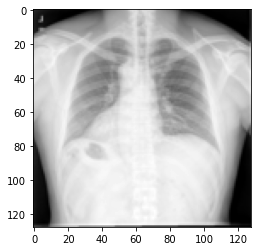

In [8]:
plt.imshow(img[0], cmap='gray')

In [9]:
img

tensor([[[-0.6627, -0.6941, -0.7333,  ..., -0.9608, -0.9765, -0.7255],
         [-0.7020, -0.7412, -0.7725,  ..., -0.9686, -0.9765, -0.7412],
         [-0.7255, -0.7725, -0.8039,  ..., -0.9765, -0.9843, -0.7569],
         ...,
         [-0.8588, -0.9059, -0.9373,  ..., -0.9922, -0.9922, -0.9922],
         [-0.7490, -0.7804, -0.8118,  ..., -0.8902, -0.9059, -0.9137],
         [-0.5216, -0.5451, -0.5686,  ..., -0.9765, -0.9843, -0.9922]],

        [[-0.6627, -0.6941, -0.7333,  ..., -0.9608, -0.9765, -0.7255],
         [-0.7020, -0.7412, -0.7725,  ..., -0.9686, -0.9765, -0.7412],
         [-0.7255, -0.7725, -0.8039,  ..., -0.9765, -0.9843, -0.7569],
         ...,
         [-0.8588, -0.9059, -0.9373,  ..., -0.9922, -0.9922, -0.9922],
         [-0.7490, -0.7804, -0.8118,  ..., -0.8902, -0.9059, -0.9137],
         [-0.5216, -0.5451, -0.5686,  ..., -0.9765, -0.9843, -0.9922]],

        [[-0.6627, -0.6941, -0.7333,  ..., -0.9608, -0.9765, -0.7255],
         [-0.7020, -0.7412, -0.7725,  ..., -0

In [10]:
bs = 32
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

In [11]:
train_index, valid_index = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=200, shuffle=True)

In [12]:
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(valid_index)

train_loader = DataLoader( dataset, batch_size=bs, sampler=train_sampler )
val_loader = DataLoader( dataset, batch_size=bs, sampler=val_sampler )

In [13]:
for x, y in train_loader:
    print(x.shape)
    print(y)
    break

torch.Size([32, 3, 128, 128])
tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1])


In [14]:
dataset.classes

['TB_NEGATIVE', 'TB_POSITIVE']

In [51]:
class KayNet01(nn.Module):
    def __init__(self):
        super().__init__()
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=2, stride=1),
            nn.ReLU()
        )
        self.convDense = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=256, kernel_size=2, stride=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=2, stride=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=2, stride=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            
            nn.Flatten(),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        out = self.residual(x)
        out = self.convDense(out)
        return out
        
        

In [52]:
def fit(epochs, model, train_batch, validation_batch, loss_func, metric, opt):
    train_losses, train_acces = [], []
    
    valid_losses , valid_acces = [], []
    for epoch in range(epochs):
        
        train_acc = 0.0
        train_loss = 0.0
        valid_acc = 0.0
        valid_loss = 0.0
        batch_train = 0.0
        batch_val = 0.0
        
        for xb, yb in train_batch:
            model.train()
            # make predictions
            preds = model(xb)
            # calculate the loss
            loss = loss_func(preds, yb)
            # Calculate the derivatives
            loss.backward()
            # update training parameters
            opt.step()
            # reset gradients to x=zero
            opt.zero_grad()
            train_loss += loss.item() * len(xb)
            # validation on training
            acc = metric(preds, yb)
            
            train_acc += acc 
            batch_train += len(xb)      

        # Validation accuracy
        with torch.no_grad():
            for xval, yval in validation_batch:
                model.eval()
                val_pred = model(xval)
                
                val_loss = loss_func(val_pred, yval).item()
               
                val_acc = metric(val_pred, yval)
                
                valid_acc += val_acc 
                valid_loss += val_loss * len(xval)
                batch_val += len(xval)              
            
        #         calculate average metrics (losses, accuracies)
        train_loss = train_loss/batch_train
        valid_loss = valid_loss/batch_val
        train_acc = train_acc/len(train_batch)
        valid_acc = valid_acc/len(validation_batch)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_acces.append(train_acc)
        valid_acces.append(valid_acc)


        print(' Epoch [{}/{}], training_loss: {:.4f}, training_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format( epoch+1, epochs, train_loss, train_acc, valid_loss, valid_acc ))
    return train_losses, train_acces, valid_losses , valid_acces

In [53]:
model = KayNet01()

In [54]:
model

KayNet01(
  (residual): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 3, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
  )
  (convDense): Sequential(
    (0): Conv2d(3, 256, kernel_size=(2, 2), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(256, 128, kernel_size=(2, 2), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [55]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum( preds == labels ).item() / len(preds)

# def accuracy(outputs, labels):
#     outputs = outputs.reshape(-1)
#     outputs = outputs > 0.5
#     return (labels == outputs).sum().item() / len(labels)

In [56]:
loss_func = F.cross_entropy
opt = RMSprop(model.parameters(), lr=0.0001)

In [50]:
%%time
history = fit(epochs=50, model=model,train_batch=train_loader,validation_batch=val_loader, loss_func=loss_func,metric=accuracy,opt=opt)

 Epoch [1/50], training_loss: 0.6938, training_acc: 0.4755, val_loss: 0.6932, val_acc: 0.4938
 Epoch [2/50], training_loss: 0.6940, training_acc: 0.4825, val_loss: 0.6931, val_acc: 0.5188
 Epoch [3/50], training_loss: 0.6936, training_acc: 0.5142, val_loss: 0.6937, val_acc: 0.4813
 Epoch [4/50], training_loss: 0.6936, training_acc: 0.4966, val_loss: 0.6940, val_acc: 0.4688
 Epoch [5/50], training_loss: 0.6935, training_acc: 0.5141, val_loss: 0.6941, val_acc: 0.4938
 Epoch [6/50], training_loss: 0.6935, training_acc: 0.5145, val_loss: 0.6944, val_acc: 0.4750
 Epoch [7/50], training_loss: 0.6931, training_acc: 0.5140, val_loss: 0.6943, val_acc: 0.4875
 Epoch [8/50], training_loss: 0.6931, training_acc: 0.5144, val_loss: 0.6945, val_acc: 0.4938
 Epoch [9/50], training_loss: 0.6931, training_acc: 0.5139, val_loss: 0.6944, val_acc: 0.4688
 Epoch [10/50], training_loss: 0.6931, training_acc: 0.5140, val_loss: 0.6942, val_acc: 0.4813
 Epoch [11/50], training_loss: 0.6930, training_acc: 0.5139

KeyboardInterrupt: 

In [24]:
train_losses, train_acces, valid_losses , valid_acces = history

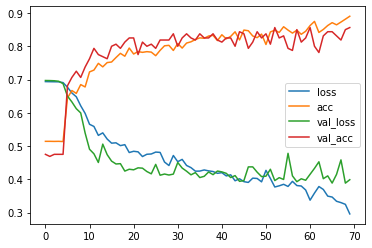

In [26]:
plt.plot(range(70), train_losses, train_acces)
# plt.legend(['loss', 'acc'])
plt.plot(range(70), valid_losses, valid_acces)
plt.legend(['loss','acc','val_loss', 'val_acc'])
plt.show()

In [27]:
test_df = pd.read_csv('Test.csv')

In [28]:
test_df

,filename,ID
0,test/GTWSHFYQ.png,GTWSHFYQ
1,test/QTFSSMGD.png,QTFSSMGD
2,test/TBLBHSYT.png,TBLBHSYT
3,test/ZKETEOFG.png,ZKETEOFG
4,test/GKTPBGZP.png,GKTPBGZP
...,...,...
77,test/UHRZNUCQ.png,UHRZNUCQ
78,test/RQZCAYRX.png,RQZCAYRX
79,test/KGOETYSK.png,KGOETYSK
80,test/ZPPGWFUO.png,ZPPGWFUO


In [29]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    yb = F.softmax(yb, dim=1)
    return yb

In [32]:
def norm(img_arr):
    im_ar = img_arr / 255.
    im_ar = (img_arr - 0.5) / 0.5
    return im_ar
def to_tensor(arr):
    return torch.from_numpy(arr).to(torch.float32)

In [33]:
im = Image.open('./'+test_df['filename'][1]).convert('RGB').resize((128,128))

tensor([0.4298], grad_fn=<SelectBackward>)


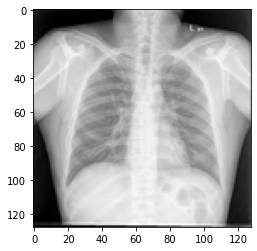

tensor([0.0409], grad_fn=<SelectBackward>)


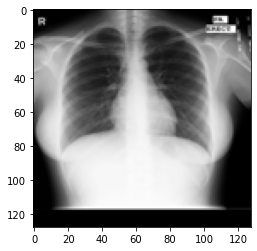

tensor([0.5730], grad_fn=<SelectBackward>)


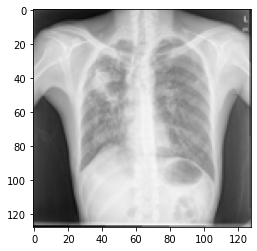

tensor([0.1781], grad_fn=<SelectBackward>)


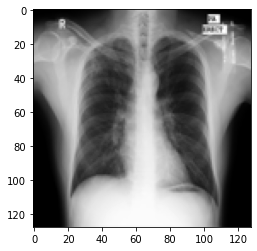

tensor([0.8748], grad_fn=<SelectBackward>)


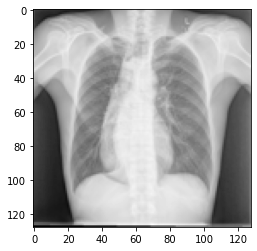

tensor([0.0197], grad_fn=<SelectBackward>)


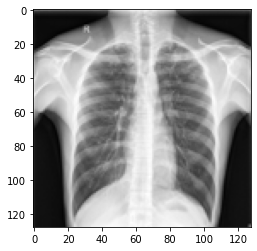

tensor([0.1260], grad_fn=<SelectBackward>)


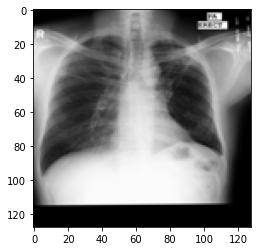

tensor([0.0517], grad_fn=<SelectBackward>)


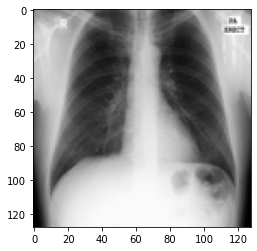

tensor([0.0304], grad_fn=<SelectBackward>)


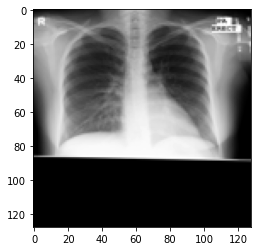

tensor([0.9459], grad_fn=<SelectBackward>)


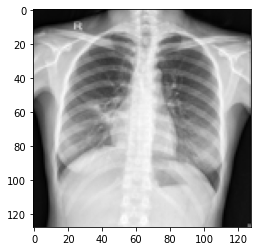

tensor([0.9242], grad_fn=<SelectBackward>)


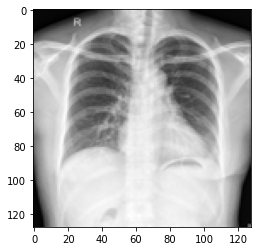

tensor([0.9848], grad_fn=<SelectBackward>)


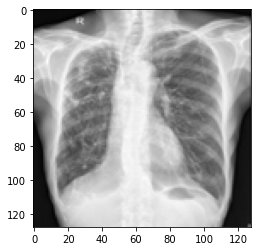

tensor([0.0824], grad_fn=<SelectBackward>)


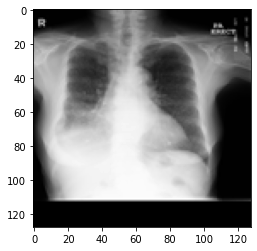

tensor([0.7475], grad_fn=<SelectBackward>)


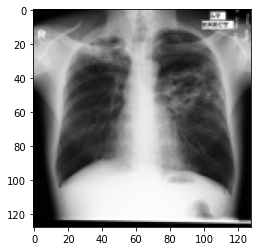

tensor([0.1711], grad_fn=<SelectBackward>)


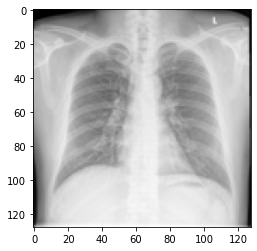

tensor([0.9609], grad_fn=<SelectBackward>)


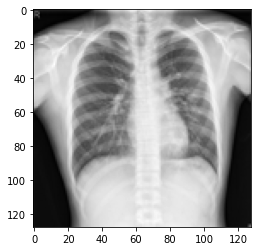

tensor([0.9904], grad_fn=<SelectBackward>)


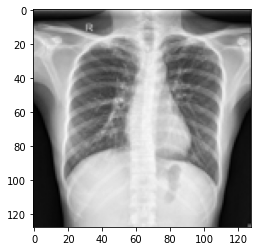

tensor([0.1437], grad_fn=<SelectBackward>)


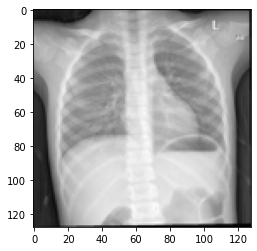

tensor([0.9902], grad_fn=<SelectBackward>)


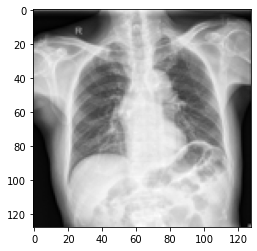

tensor([0.2676], grad_fn=<SelectBackward>)


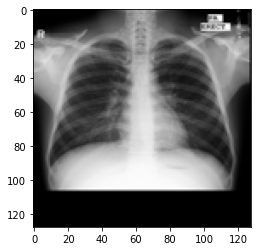

tensor([0.0386], grad_fn=<SelectBackward>)


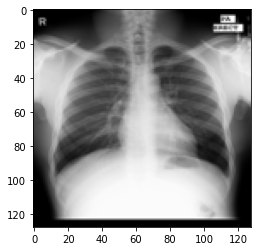

tensor([0.4410], grad_fn=<SelectBackward>)


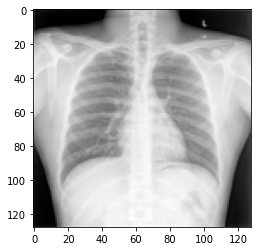

tensor([0.6609], grad_fn=<SelectBackward>)


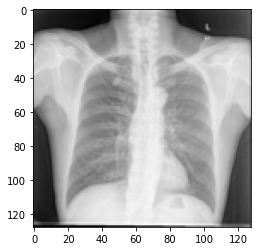

tensor([0.6236], grad_fn=<SelectBackward>)


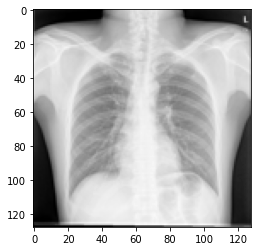

tensor([0.0663], grad_fn=<SelectBackward>)


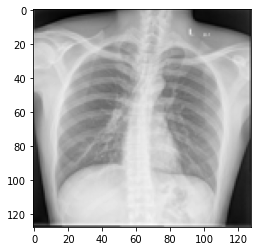

tensor([0.2216], grad_fn=<SelectBackward>)


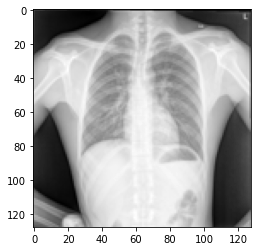

tensor([0.9834], grad_fn=<SelectBackward>)


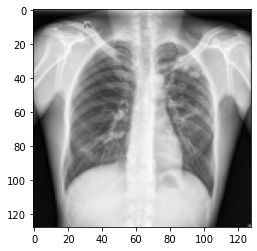

tensor([0.0580], grad_fn=<SelectBackward>)


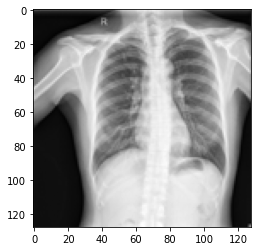

tensor([0.1060], grad_fn=<SelectBackward>)


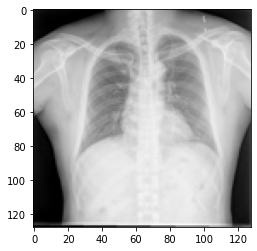

tensor([0.0950], grad_fn=<SelectBackward>)


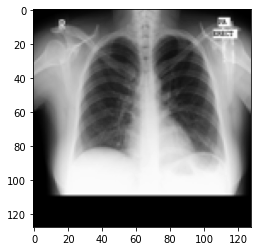

tensor([0.4060], grad_fn=<SelectBackward>)


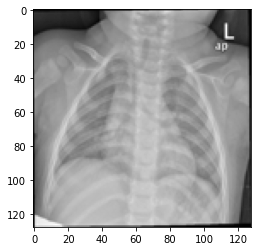

tensor([0.9865], grad_fn=<SelectBackward>)


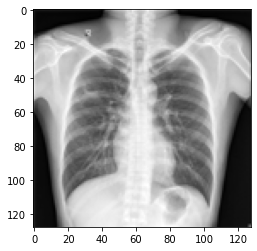

tensor([0.0203], grad_fn=<SelectBackward>)


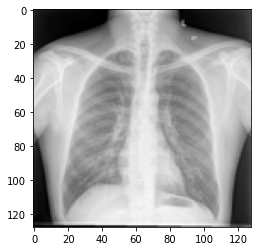

tensor([0.9548], grad_fn=<SelectBackward>)


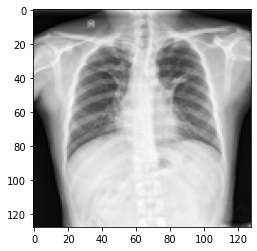

tensor([0.7979], grad_fn=<SelectBackward>)


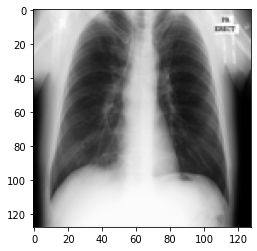

tensor([0.6940], grad_fn=<SelectBackward>)


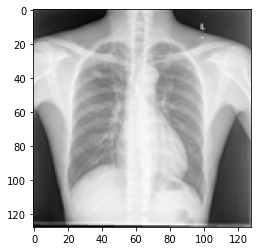

tensor([0.8575], grad_fn=<SelectBackward>)


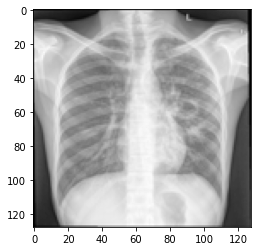

tensor([0.0417], grad_fn=<SelectBackward>)


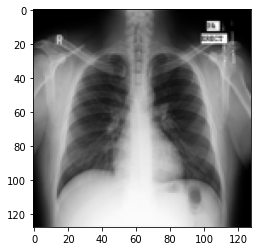

tensor([0.1353], grad_fn=<SelectBackward>)


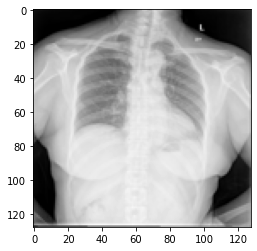

tensor([0.7250], grad_fn=<SelectBackward>)


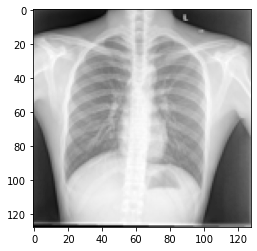

tensor([0.0466], grad_fn=<SelectBackward>)


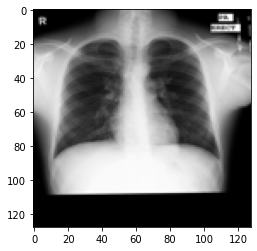

tensor([0.9529], grad_fn=<SelectBackward>)


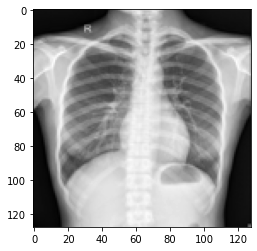

tensor([0.3801], grad_fn=<SelectBackward>)


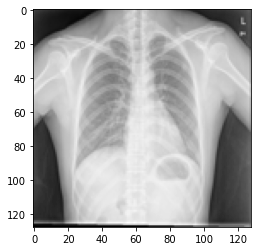

tensor([0.7802], grad_fn=<SelectBackward>)


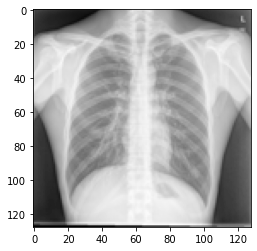

tensor([0.0381], grad_fn=<SelectBackward>)


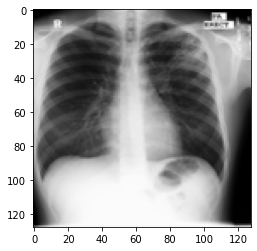

tensor([0.0818], grad_fn=<SelectBackward>)


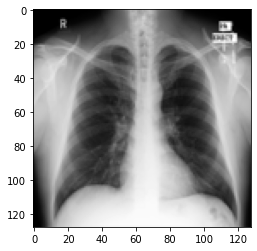

tensor([0.0278], grad_fn=<SelectBackward>)


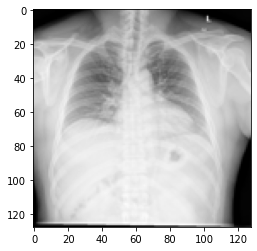

tensor([0.0687], grad_fn=<SelectBackward>)


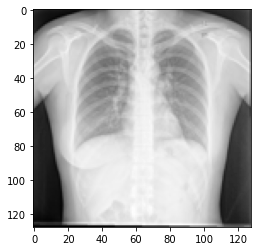

tensor([0.0867], grad_fn=<SelectBackward>)


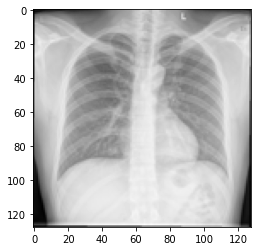

tensor([0.0241], grad_fn=<SelectBackward>)


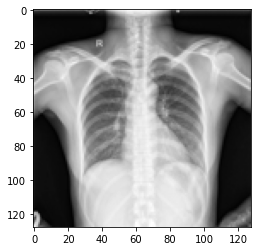

tensor([0.1204], grad_fn=<SelectBackward>)


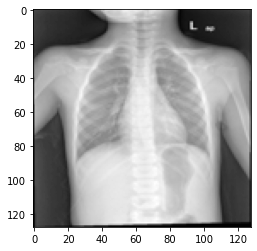

tensor([0.3964], grad_fn=<SelectBackward>)


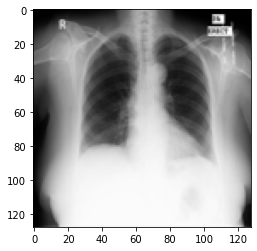

tensor([0.1600], grad_fn=<SelectBackward>)


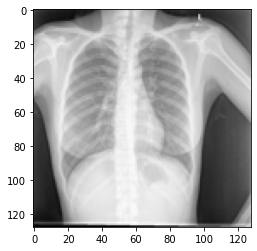

tensor([0.6672], grad_fn=<SelectBackward>)


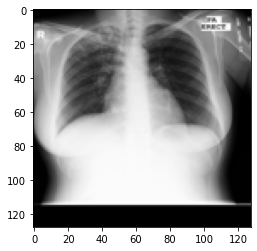

tensor([0.7017], grad_fn=<SelectBackward>)


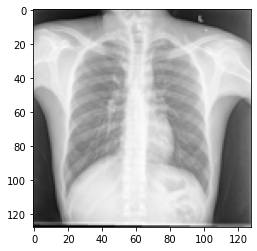

tensor([0.6282], grad_fn=<SelectBackward>)


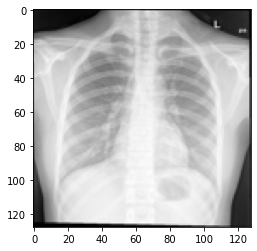

tensor([0.0883], grad_fn=<SelectBackward>)


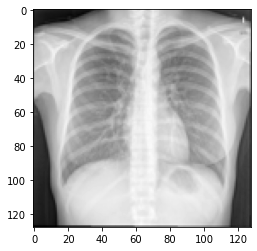

tensor([0.0539], grad_fn=<SelectBackward>)


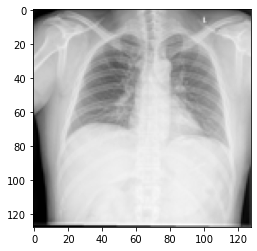

tensor([0.9218], grad_fn=<SelectBackward>)


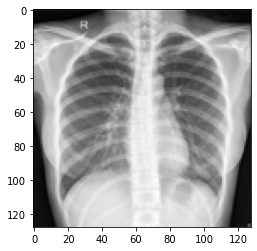

tensor([0.9819], grad_fn=<SelectBackward>)


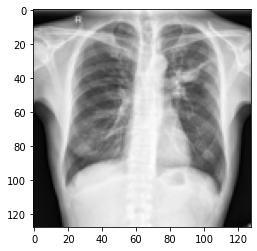

tensor([0.0332], grad_fn=<SelectBackward>)


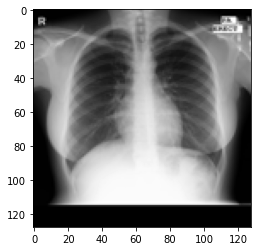

tensor([0.1371], grad_fn=<SelectBackward>)


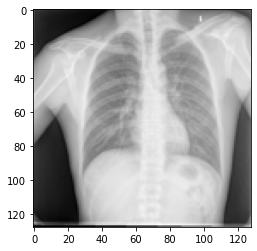

tensor([0.0532], grad_fn=<SelectBackward>)


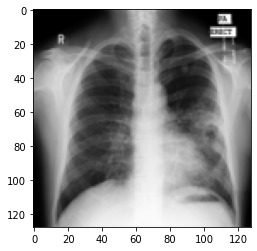

tensor([0.8694], grad_fn=<SelectBackward>)


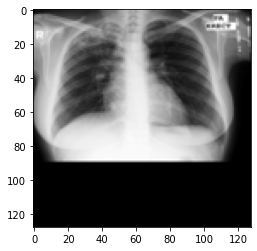

tensor([0.9939], grad_fn=<SelectBackward>)


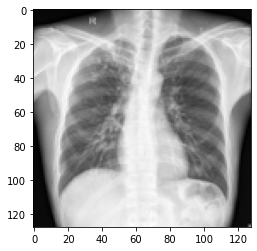

tensor([0.9611], grad_fn=<SelectBackward>)


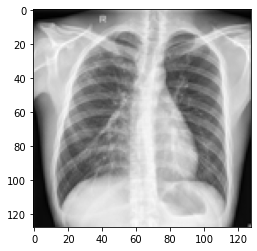

tensor([0.0534], grad_fn=<SelectBackward>)


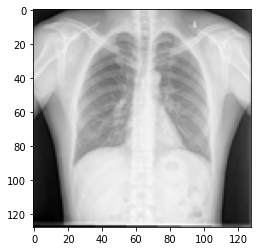

tensor([0.9229], grad_fn=<SelectBackward>)


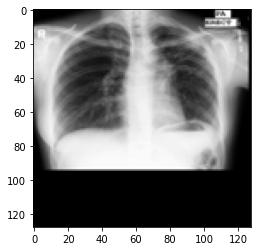

tensor([0.8212], grad_fn=<SelectBackward>)


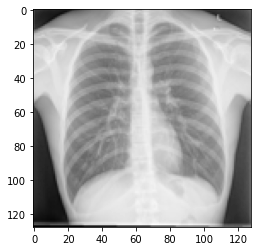

tensor([0.9630], grad_fn=<SelectBackward>)


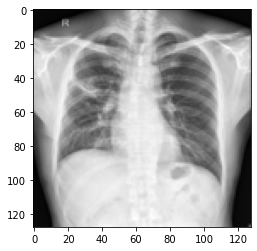

tensor([0.8373], grad_fn=<SelectBackward>)


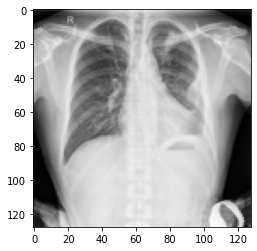

tensor([0.9785], grad_fn=<SelectBackward>)


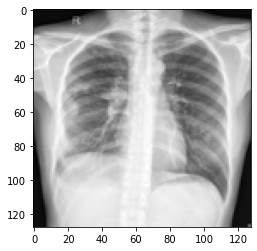

tensor([0.2893], grad_fn=<SelectBackward>)


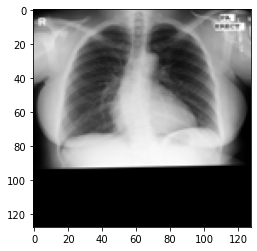

tensor([0.8907], grad_fn=<SelectBackward>)


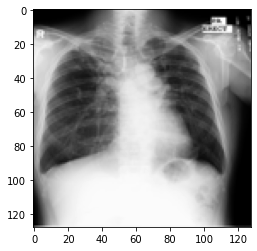

tensor([0.9234], grad_fn=<SelectBackward>)


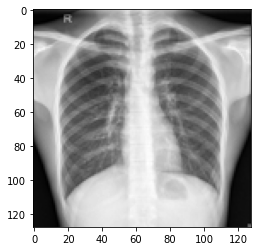

tensor([0.9819], grad_fn=<SelectBackward>)


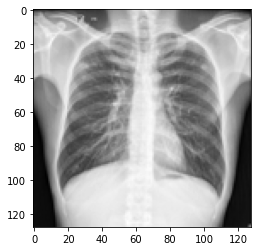

tensor([0.0290], grad_fn=<SelectBackward>)


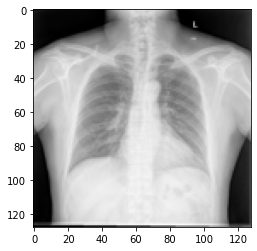

tensor([0.9705], grad_fn=<SelectBackward>)


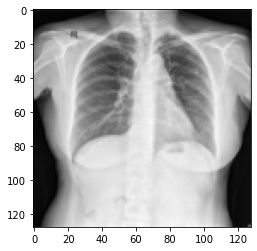

tensor([0.1806], grad_fn=<SelectBackward>)


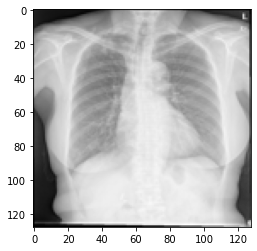

tensor([0.1373], grad_fn=<SelectBackward>)


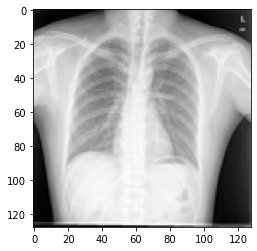

tensor([0.1806], grad_fn=<SelectBackward>)


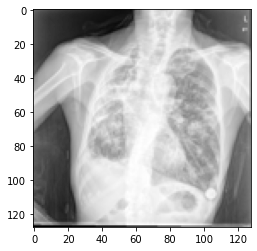

tensor([0.9670], grad_fn=<SelectBackward>)


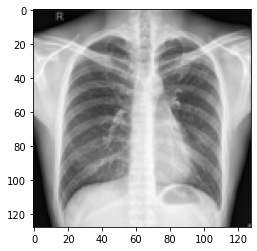

In [34]:
prob = []
for m in test_df['filename']:
    im = Image.open('./'+m).convert('RGB').resize((128,128))
    im = np.asarray(im) / 255.
    im = (im -0.5)/0.5
    im_t = to_tensor(im)
    im_t = im_t.permute(2,0,1)
    p = predict_image(im_t, model)[:,1]
    prob.append(p.item())
    print(p)
    plt.imshow(im_t[0], cmap='gray')
    plt.show()
# test_df['filename'][1]

In [35]:
prob

[0.4297828674316406,
 0.0409000925719738,
 0.5730232000350952,
 0.17806792259216309,
 0.8748337626457214,
 0.019749540835618973,
 0.12601794302463531,
 0.051711343228816986,
 0.0304129458963871,
 0.9459254741668701,
 0.9242444634437561,
 0.9848490357398987,
 0.08235066384077072,
 0.7474613189697266,
 0.17107686400413513,
 0.960878849029541,
 0.9904038906097412,
 0.14368051290512085,
 0.9901756644248962,
 0.2676061689853668,
 0.03864724934101105,
 0.44097110629081726,
 0.6608708500862122,
 0.6236017942428589,
 0.06630514562129974,
 0.221597820520401,
 0.9833906888961792,
 0.05804423615336418,
 0.10597783327102661,
 0.09500087797641754,
 0.40597304701805115,
 0.986492931842804,
 0.020277490839362144,
 0.9547706246376038,
 0.7979071736335754,
 0.6940302848815918,
 0.8575355410575867,
 0.041734728962183,
 0.1352594941854477,
 0.7249854207038879,
 0.04658627137541771,
 0.9528711438179016,
 0.38008689880371094,
 0.7802023887634277,
 0.03813615068793297,
 0.08180870115756989,
 0.0278322268277

In [36]:
sol_df = pd.read_csv('SampleSubmission.csv')

In [37]:
sol_trained = sol_df.copy()

In [38]:
sol_trained

,ID,LABEL
0,GTWSHFYQ,0
1,QTFSSMGD,0
2,TBLBHSYT,0
3,ZKETEOFG,0
4,GKTPBGZP,0
...,...,...
77,UHRZNUCQ,0
78,RQZCAYRX,0
79,KGOETYSK,0
80,ZPPGWFUO,0


In [39]:
sol_trained['LABEL'] = prob

In [502]:
cnn = pd.read_csv('cnn2.csv')

In [516]:
cnn2 = cnn = pd.read_csv('cnn3.csv')

In [517]:
a = cnn2['LABEL'].values

In [518]:
b = cnn['LABEL'].values

In [40]:
sol_trained.to_csv('pytorch5.csv', index=False)